In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
_FOLDER = "../data/"
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from skopt import BayesSearchCV

## autoML

import json

In [2]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
#     fig = plt.figure(figsize=(5, 5))
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [3]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCLAndParams.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(trainTestSplit.keys())

88

In [39]:
params = ['param_1', 'param_2','param_3','param_4']
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC'] + params
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ resp_labels+params)

drugId = 344

drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
notXValuesFilter = resp_labels + notIncludeColumns + conc_labels
trainXValues = trainData.drop(columns = notXValuesFilter)
trainYValues = trainData[resp_labels]

trainX = trainXValues.reset_index(drop=True).to_numpy()
trainY = trainYValues.reset_index(drop=True).to_numpy()

testXValues = testData.drop(columns = notXValuesFilter)
testYValues = testData[resp_labels]
testParamsValues = testData[params]

testX = testXValues.reset_index(drop=True).to_numpy()
testY = testYValues.reset_index(drop=True).to_numpy()
testParams = testParamsValues.reset_index(drop=True).to_numpy()

base_estimator = SVR()
valModel = MultiOutputRegressor(BaggingRegressor(base_estimator))

searchSpace = {
    'estimator__n_estimators': (2, 100),
    'estimator__max_samples': (0.1, 1.0),
    'estimator__max_features': (0.1, 1.0),
    'estimator__bootstrap': [True],
    'estimator__bootstrap_features': [True, False],
    'estimator__base_estimator__C': (0.1, 10.0),
    'estimator__base_estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__base_estimator__gamma': (0.001, 1.0),
    'estimator__base_estimator__degree': (2, 4),
    'estimator__base_estimator__epsilon': (0.01, 0.5)
}

bayes = BayesSearchCV(valModel, searchSpace, cv=5, n_iter=20, n_jobs=-1)
bayes.fit(trainX, trainY)
print("Best hyperparameters: ", bayes.best_params_)
bestParams = bayes.best_params_
n_estimators = 5
svm_bagging = MultiOutputRegressor(BaggingRegressor(base_estimator=SVR(kernel=bestParams['estimator__base_estimator__kernel'], 
                                                                       C=bestParams['estimator__base_estimator__C'],
                                                                      gamma=bestParams['estimator__base_estimator__gamma'],
                                                                       degree=bestParams['estimator__base_estimator__degree'],
                                                                       epsilon=bestParams['estimator__base_estimator__epsilon'],
                                                                      ), 
                                                    n_estimators=bestParams['estimator__n_estimators'],
                                                    max_samples=bestParams['estimator__max_samples'],
                                                    max_features=bestParams['estimator__max_features'],
                                                    bootstrap=bestParams['estimator__bootstrap'],
                                                    bootstrap_features=bestParams['estimator__bootstrap_features']
                                                   ))
svm_bagging.fit(trainX, trainY)

yTrainPredict = svm_bagging.predict(trainX)
yTestPredict = svm_bagging.predict(testX)

test_mse = mean_squared_error(yTrainPredict, trainY)
trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
trueResult[resp_labels] = testY
trueResult[params] = testParams
trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)
result = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
result[pred_resp_labels] = yTestPredict
predictedResults = predictedResults.append(result,ignore_index=True,sort=False)

Best hyperparameters:  OrderedDict([('estimator__base_estimator__C', 8.88814894306605), ('estimator__base_estimator__degree', 4), ('estimator__base_estimator__epsilon', 0.01), ('estimator__base_estimator__gamma', 0.1034672588516128), ('estimator__base_estimator__kernel', 'rbf'), ('estimator__bootstrap', True), ('estimator__bootstrap_features', False), ('estimator__max_features', 1.0), ('estimator__max_samples', 0.796862189338511), ('estimator__n_estimators', 28)])


In [40]:
trueResults

,DRUG_COSMICID,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.0,0.971586,0.906044,0.954482,0.917586,0.279158,0.258352,0.233342,0.204716,0.197107,-16.424564,0.958175,23.736499,0.222941
1,344_717431,1.0,1.037550,1.091360,1.143341,1.097121,0.947674,0.659068,0.011337,0.015206,0.015280,-9.979214,1.054327,25.806256,0.003961
2,344_910925,1.0,1.029277,1.108623,0.851732,0.782264,0.013142,0.003812,0.004973,0.006074,0.007326,-19.679407,0.997509,25.848962,0.004848
3,344_908457,1.0,1.013743,1.001765,0.947623,0.911589,0.695498,0.440803,0.173345,0.013123,0.009104,-2.704682,0.995417,6.327667,-0.086482
4,344_910853,1.0,0.951634,0.922052,0.687362,0.582085,0.006510,0.004951,0.006649,0.003550,0.003617,-5.761424,0.934020,7.109135,-0.029411
5,344_908123,1.0,0.967067,0.945210,0.987415,0.996366,0.913169,0.745015,0.009191,0.005302,0.006474,-15.216992,0.968251,40.483854,0.004931
6,344_905962,1.0,1.005736,0.992808,0.995439,0.973973,0.444915,0.193558,0.004517,0.005456,0.002408,-6.325899,1.009074,10.630912,0.007470
7,344_722045,1.0,0.968492,0.976498,0.898752,0.746105,0.180655,0.086766,0.020786,0.006432,0.006455,-8.228032,0.965678,11.533052,0.018718
8,344_917486,1.0,0.986723,0.914477,1.061182,0.754083,0.253797,0.016887,0.008990,0.010619,0.008801,-7.537546,0.990734,10.846830,0.001184
9,344_906826,1.0,1.000641,1.065012,1.057747,0.963716,0.457469,0.286658,0.260749,0.062882,0.024845,-4.879638,1.043312,8.096253,0.088487


In [41]:
predictedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,344_910851,1.0,1.005739,0.991453,0.953885,0.822204,0.576607,0.268113,0.098537,0.013874,0.011403
1,344_717431,1.0,0.999442,0.963774,0.909235,0.763033,0.580013,0.280242,0.084817,0.013410,0.011464
2,344_910925,1.0,1.005562,0.993557,0.941599,0.798924,0.568818,0.283551,0.095500,0.014241,0.011697
3,344_908457,1.0,1.008762,0.990238,0.948388,0.796202,0.532574,0.275874,0.095697,0.015869,0.013118
4,344_910853,1.0,1.008376,0.989629,0.950829,0.813161,0.562088,0.310234,0.110532,0.015586,0.012935
5,344_908123,1.0,1.007638,0.988730,0.942471,0.797082,0.542910,0.272104,0.095764,0.016079,0.013191
6,344_905962,1.0,1.008698,0.991698,0.950541,0.811824,0.560197,0.284285,0.090048,0.015449,0.012708
7,344_722045,1.0,1.007354,0.988705,0.944847,0.797135,0.523425,0.262186,0.095855,0.015420,0.012762
8,344_917486,1.0,1.008155,0.990059,0.949528,0.798363,0.542990,0.278835,0.092251,0.015697,0.013042
9,344_906826,1.0,1.008689,0.993843,0.948038,0.805512,0.545523,0.285109,0.098975,0.016126,0.013166


In [42]:
def showTestPredResponses(drugIdCosmic):
    samplePredicted = predictedResults[predictedResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    predictedY = samplePredicted[pred_resp_labels]
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    xValues = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
    trueY = trueY[resp_labels]
    plt.title(drugIdCosmic + " dosage against response")
    plt.scatter(xValues, predictedY, color='b', label='Predicted')
    plt.scatter(xValues, trueY, color='y', label='True')
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.show()

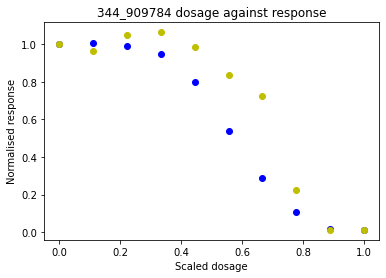

In [43]:
showTestPredResponses('344_909784')

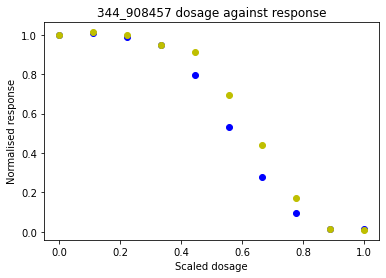

In [44]:
showTestPredResponses('344_908457')

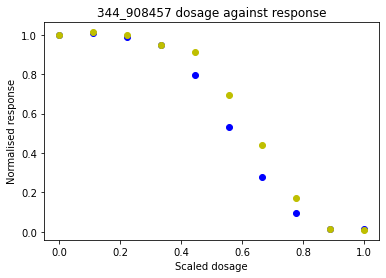

In [45]:
showTestPredResponses('344_908457')

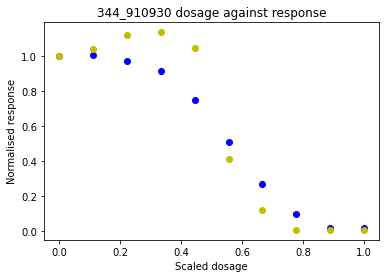

In [46]:
showTestPredResponses('344_910930')